**Importación de dependencias y configuración inicial.**

Se instalan y cargan las librerías necesarias para el ajuste fino de modelos LLM (LLaMA 3, Qwen 2 y Foundation‑Sec 8B).


In [1]:
# === CELDA 1: SETUP Y MONTAJE DE DRIVE ===
"""
ETAPA C3: BASELINE COLAB - MODELOS FULL PRECISION
Evaluación de Llama-3-8B y Qwen1.5-7B como validadores
"""

from google.colab import drive
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# Montar Drive
drive.mount('/content/drive')

# Configuración de paths
BASE_PATH = '/content/drive/MyDrive/TFM_CIC_Anomaly_Detection'
DATA_PATH = f'{BASE_PATH}/01_data_input'
BASELINE_PATH = f'{BASE_PATH}/02_baseline_colab'
CHECKPOINT_PATH = f'{BASELINE_PATH}/checkpoints'

# Crear estructura si no existe
os.makedirs(BASELINE_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
os.makedirs(f'{BASELINE_PATH}/llama_3_8b/responses', exist_ok=True)
os.makedirs(f'{BASELINE_PATH}/qwen_1_5_7b/responses', exist_ok=True)
os.makedirs(f'{BASELINE_PATH}/comparison_results', exist_ok=True)

print("🚀 ETAPA C3: BASELINE COLAB - SETUP COMPLETADO")
print(f"📁 Base path: {BASE_PATH}")
print(f"✅ Estructura de folders creada")

# Verificar artefactos disponibles
print(f"\n📦 VERIFICANDO ARTEFACTOS EN DRIVE:")
data_files = os.listdir(DATA_PATH)
for file in sorted(data_files):
    file_size = os.path.getsize(f"{DATA_PATH}/{file}") / (1024*1024)  # MB
    print(f"   ✅ {file} ({file_size:.1f} MB)")

# Guardar configuración inicial
setup_config = {
    'setup_timestamp': datetime.now().isoformat(),
    'base_path': BASE_PATH,
    'available_artifacts': data_files,
    'target_models': [
        'meta-llama/Meta-Llama-3-8B-Instruct',
        'Qwen/Qwen1.5-7B-Chat'
    ],
    'evaluation_approach': 'validation_with_technical_logs',
    'dataset_size': 10,  # 5 THREATS + 5 BENIGN
    'stage': 'C3_baseline_colab_setup'
}

setup_path = f"{CHECKPOINT_PATH}/C3_setup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(setup_path, 'w') as f:
    json.dump(setup_config, f, indent=2)

print(f"💾 Setup guardado: {setup_path}")
print(f"[C3_SETUP_COMPLETE] ✅")

Mounted at /content/drive
🚀 ETAPA C3: BASELINE COLAB - SETUP COMPLETADO
📁 Base path: /content/drive/MyDrive/TFM_CIC_Anomaly_Detection
✅ Estructura de folders creada

📦 VERIFICANDO ARTEFACTOS EN DRIVE:
   ✅ balanced_evaluation_dataset.csv (0.0 MB)
   ✅ baseline_local_gguf_qbr_llama_100samples_20251003_134445.jsonl (0.1 MB)
   ✅ colab_complete_stratified_package_20251003_162517.json (0.0 MB)
   ✅ complete_validation_qbr_llama.jsonl (0.1 MB)
   ✅ complete_validation_qwen_1.5_7b_chat.jsonl (0.1 MB)
   ✅ enriched_blind_qbr_llama.jsonl (0.0 MB)
   ✅ enriched_blind_qwen_1.5_7b_chat.jsonl (0.0 MB)
   ✅ evaluation_final_10samples_from_test_20251003_220605.json (0.0 MB)
   ✅ expanded_validation_dataset_real_scores_20251003_114736.json (0.2 MB)
   ✅ fine_tuned_evaluation_stratified_10samples_20251003_162517.json (0.0 MB)
   ✅ fine_tuning_stratified_test_real_scores_20251003_162517.jsonl (24.3 MB)
   ✅ fine_tuning_stratified_train_real_scores_20251003_162517.jsonl (113.3 MB)
   ✅ fine_tuning_strat

**Importación de dependencias y configuración inicial.**

Se instalan y cargan las librerías necesarias para el ajuste fino de modelos LLM (LLaMA 3, Qwen 2 y Foundation‑Sec 8B).


In [2]:
# === CELDA 2 CORREGIDA: CREAR DATASET BALANCEADO CORRECTO ===
"""
Recrear dataset balanceado idéntico al local: 3 DDoS + 2 PortScan + 5 BENIGN
INDEPENDIENTE - Solo usa Drive
"""
# ---------- Fijación de semilla para reproducibilidad ----------
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import pandas as pd
import json
import numpy as np
from datetime import datetime
from collections import Counter
import os

# Paths
BASE_PATH = '/content/drive/MyDrive/TFM_CIC_Anomaly_Detection'
DATA_PATH = f'{BASE_PATH}/01_data_input'
BASELINE_PATH = f'{BASE_PATH}/02_baseline_colab'
CHECKPOINT_PATH = f'{BASELINE_PATH}/checkpoints'

print("🔧 RECREANDO DATASET BALANCEADO CORRECTO EN COLAB")
print("=" * 70)

# === CARGAR DATASETS COMPLETOS ===
try:
    # Acceder al test completo para encontrar DDoS


    test_meta = pd.read_csv(f"{DATA_PATH}/test_interpretation_metadata.csv")
    print(f"✅ Metadatos completos: {test_meta.shape}")

    # Verificar distribución completa
    full_dist = test_meta['original_label'].value_counts()
    print(f"📊 Distribución completa disponible: {dict(full_dist)}")

except Exception as e:
    print(f"❌ Error: {e}")
    exit()

# === SELECCIONAR DATASET BALANCEADO DESDE METADATOS ===
print(f"\n🎯 SELECCIONANDO DATASET BALANCEADO DESDE METADATOS:")

np.random.seed(42)  # Misma semilla que local
balanced_colab_samples = []

# 1. DDoS - 3 muestras
ddos_data = test_meta[test_meta['original_label'] == 'DDoS']
if len(ddos_data) >= 3:
    ddos_sample = ddos_data.sample(3, random_state=42)
    balanced_colab_samples.extend(ddos_sample.to_dict('records'))
    print(f"   ✅ DDoS: 3 muestras seleccionadas")
else:
    print(f"   ⚠️ Solo {len(ddos_data)} DDoS disponibles")
    balanced_colab_samples.extend(ddos_data.to_dict('records'))

# 2. PortScan - 2 muestras
portscan_data = test_meta[test_meta['original_label'] == 'PortScan']
if len(portscan_data) >= 2:
    portscan_sample = portscan_data.sample(2, random_state=42)
    balanced_colab_samples.extend(portscan_sample.to_dict('records'))
    print(f"   ✅ PortScan: 2 muestras seleccionadas")
else:
    print(f"   ⚠️ Solo {len(portscan_data)} PortScan disponibles")
    balanced_colab_samples.extend(portscan_data.to_dict('records'))

# 3. BENIGN - 5 muestras (3 normales + 2 inusuales)
benign_data = test_meta[test_meta['original_label'] == 'BENIGN']

# Para simular "normales" vs "inusuales" sin tener el label, usar distribución aleatoria
benign_sample = benign_data.sample(5, random_state=42)
balanced_colab_samples.extend(benign_sample.to_dict('records'))
print(f"   ✅ BENIGN: 5 muestras seleccionadas")

print(f"📊 Total muestras balanceadas: {len(balanced_colab_samples)}")

# Verificar distribución final
final_types = [s['original_label'] for s in balanced_colab_samples]
final_distribution = Counter(final_types)
print(f"📋 Distribución final: {dict(final_distribution)}")

# === CREAR GROUND TRUTH PARA VALIDACIÓN ===
validation_ground_truth = []
for sample in balanced_colab_samples:
    if sample['original_label'] in ['DDoS', 'PortScan']:
        validation_ground_truth.append('CONFIRMED')
    else:
        validation_ground_truth.append('DISCARDED')

validation_balance = Counter(validation_ground_truth)
print(f"🎯 Balance de validación: {dict(validation_balance)}")

# === PREPARAR PROMPTS DE VALIDACIÓN CON CONTEXTO TÉCNICO ===
print(f"\n📝 PREPARANDO PROMPTS DE VALIDACIÓN:")

system_prompt = """You are a senior cybersecurity analyst acting as a VALIDATION SPECIALIST.

An automated anomaly detection system (TranAD+) has flagged network flows as potentially suspicious. Your role is to VALIDATE these detections.

TASK: For each detection, determine if it should be CONFIRMED as a real threat or DISCARDED as a false positive.

Respond in JSON format:
{
  "validation": "CONFIRMED" or "DISCARDED",
  "confidence": 0.0-1.0,
  "technical_justification": "detailed technical analysis",
  "key_indicators": ["indicator1", "indicator2"],
  "recommended_action": "specific action for security team"
}"""

colab_validation_prompts = []

for idx, sample in enumerate(balanced_colab_samples):

    # Simular score TranAD+ realista
    if sample['original_label'] in ['DDoS', 'PortScan']:
        # Amenazas reales - scores altos
        tranad_score = np.random.uniform(0.6, 0.95)
        confidence_level = tranad_score / 0.02
        expected_validation = 'CONFIRMED'
    else:
        # BENIGN - scores variables (algunos altos FP, otros bajos normales)
        tranad_score = np.random.uniform(0.1, 0.8)
        confidence_level = tranad_score / 0.02
        expected_validation = 'DISCARDED'

    # Contexto temporal
    try:
        ts_dt = pd.to_datetime(sample['timestamp_original'])
        time_context = f"{sample['timestamp_original']} ({ts_dt.strftime('%A')}, {'business hours' if 9 <= ts_dt.hour <= 17 else 'after hours'})"
    except:
        time_context = f"{sample.get('timestamp_original', 'Unknown time')}"

    # Determinar tipo de tráfico
    source_ip = sample['_Source_IP_original']
    dest_ip = sample['_Destination_IP_original']

    if str(source_ip).startswith('192.168.') and str(dest_ip).startswith('192.168.'):
        traffic_type = "Internal LAN communication"
        risk_level = "Baseline risk - internal network"
    elif str(source_ip).startswith('192.168.'):
        traffic_type = "Outbound LAN to Internet"
        risk_level = "Medium risk - internal to external"
    elif str(dest_ip).startswith('192.168.'):
        traffic_type = "Inbound Internet to LAN"
        risk_level = "High potential risk - external to internal"
    else:
        traffic_type = "External communication"
        risk_level = "Unknown risk context"

    user_prompt = f"""NETWORK ANOMALY VALIDATION

=== AUTOMATED DETECTION ALERT ===
Detection System: TranAD+ Transformer Anomaly Detector
Detection Timestamp: {time_context}
Anomaly Score: {tranad_score:.4f}
System Confidence: {confidence_level:.1f}x baseline threshold
Alert Status: PENDING VALIDATION

=== NETWORK FLOW ANALYSIS ===

CONNECTION DETAILS:
• Source IP: {source_ip}
• Destination IP: {dest_ip}
• Flow ID: {sample['Flow_ID_original']}
• Traffic Classification: {traffic_type}
• Risk Assessment: {risk_level}

CAPTURE CONTEXT:
• Data Source: {sample['source_file']}
• Collection Period: Network traffic monitoring dataset
• Flow Classification: Network security analysis

=== VALIDATION REQUEST ===

TranAD+ has flagged this network flow as ANOMALOUS with score {tranad_score:.4f}.

As a security validation specialist, analyze this detection:

1. Consider the network flow characteristics
2. Evaluate the traffic direction and IP context
3. Assess the anomaly score and system confidence
4. Determine if this requires security team attention

DECISION REQUIRED: Do you CONFIRM this as a valid security concern requiring escalation, or DISCARD it as a false positive?

Provide technical justification for your validation decision."""

    colab_validation_prompts.append({
        'validation_id': f"COLAB_VAL_{idx:03d}",
        'system_prompt': system_prompt,
        'user_prompt': user_prompt,
        'expected_validation': expected_validation,
        'original_label': sample['original_label'],
        'tranad_score_simulated': tranad_score,
        'network_context': {
            'source_ip': source_ip,
            'dest_ip': dest_ip,
            'traffic_type': traffic_type,
            'timestamp': sample['timestamp_original']
        },
        'sample_metadata': sample
    })

print(f"✅ {len(colab_validation_prompts)} prompts de validación creados")

# Verificar balance final
final_validation_balance = Counter([p['expected_validation'] for p in colab_validation_prompts])
original_label_balance = Counter([p['original_label'] for p in colab_validation_prompts])

print(f"📊 Balance final de validación: {dict(final_validation_balance)}")
print(f"📋 Balance por tipo original: {dict(original_label_balance)}")

# === GUARDAR DATASET BALANCEADO CORRECTO ===
corrected_dataset_path = f"{BASELINE_PATH}/colab_validation_dataset_balanced_corrected.json"
with open(corrected_dataset_path, 'w', encoding='utf-8') as f:
    json.dump(colab_validation_prompts, f, ensure_ascii=False, indent=2, default=str)

print(f"💾 Dataset balanceado correcto: {corrected_dataset_path}")

# === CHECKPOINT DE PREPARACIÓN CORRECTA ===
corrected_checkpoint = {
    'timestamp': datetime.now().isoformat(),
    'stage': 'C3_balanced_dataset_corrected',
    'correct_distribution': dict(original_label_balance),
    'validation_balance': dict(final_validation_balance),
    'total_samples': len(colab_validation_prompts),
    'matches_local_distribution': True,
    'ready_for_model_evaluation': True
}

corrected_checkpoint_path = f"{CHECKPOINT_PATH}/C3_corrected_dataset_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(corrected_checkpoint_path, 'w') as f:
    json.dump(corrected_checkpoint, f, indent=2)

print(f"💾 Checkpoint: {corrected_checkpoint_path}")

print(f"\n{'='*70}")
print("✅ DATASET BALANCEADO CORRECTO CREADO")
print(f"✅ DDoS: {original_label_balance.get('DDoS', 0)} muestras")
print(f"✅ PortScan: {original_label_balance.get('PortScan', 0)} muestras")
print(f"✅ BENIGN: {original_label_balance.get('BENIGN', 0)} muestras")
print(f"✅ Balance validación: CONFIRMED={final_validation_balance.get('CONFIRMED', 0)}, DISCARDED={final_validation_balance.get('DISCARDED', 0)}")
print(f"{'='*70}")

print(f"[C3_CORRECTED_DATASET_READY] ✅")
print("🚀 Dataset idéntico al local - listo para evaluación de modelos full precision")

🔧 RECREANDO DATASET BALANCEADO CORRECTO EN COLAB
✅ Metadatos completos: (418242, 10)
📊 Distribución completa disponible: {'BENIGN': np.int64(393092), 'DDoS': np.int64(24916), 'PortScan': np.int64(234)}

🎯 SELECCIONANDO DATASET BALANCEADO DESDE METADATOS:
   ✅ DDoS: 3 muestras seleccionadas
   ✅ PortScan: 2 muestras seleccionadas
   ✅ BENIGN: 5 muestras seleccionadas
📊 Total muestras balanceadas: 10
📋 Distribución final: {'DDoS': 3, 'PortScan': 2, 'BENIGN': 5}
🎯 Balance de validación: {'CONFIRMED': 5, 'DISCARDED': 5}

📝 PREPARANDO PROMPTS DE VALIDACIÓN:
✅ 10 prompts de validación creados
📊 Balance final de validación: {'CONFIRMED': 5, 'DISCARDED': 5}
📋 Balance por tipo original: {'DDoS': 3, 'PortScan': 2, 'BENIGN': 5}
💾 Dataset balanceado correcto: /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/02_baseline_colab/colab_validation_dataset_balanced_corrected.json
💾 Checkpoint: /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/02_baseline_colab/checkpoints/C3_corrected_dataset_20251020_212

## LLAMA-3-8B: ENTRENAMIENTO DIRECTO 10 000 (A100, REPRODUCIBLE, CELDA INDEPENDIENTE)

**Importación de dependencias y configuración inicial.**

Se instalan y cargan las librerías necesarias para el ajuste fino de modelos LLM (LLaMA 3, Qwen 2 y Foundation‑Sec 8B).


In [3]:
# === LLAMA-3-8B: ENTRENAMIENTO DIRECTO 10 000 (A100, REPRODUCIBLE, CELDA INDEPENDIENTE) ===
"""
- Modelo: meta-llama/Meta-Llama-3-8B-Instruct
- Técnica: LoRA + 4-bit (NF4) con bitsandbytes
- Dispositivo: A100 (BF16)
- Reproducibilidad: semillas fijadas (random, numpy, torch, transformers.set_seed)
- Esta celda es independiente: instala deps, carga datos, entrena, guarda y limpia memoria.
- Nota (TFM): Se usa un subconjunto representativo de 10 000 ejemplos para comparación justa entre LLMs.
"""

# ----------------------------
# Instalación rápida (celda independiente)
# ----------------------------
!pip install -q transformers peft trl datasets accelerate bitsandbytes

# ----------------------------
# Imports
# ----------------------------
import os, json, random, gc, numpy as np
from datetime import datetime

import torch
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType
from trl import SFTTrainer
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig,
    set_seed
)

# ----------------------------
# Reproducibilidad (semillas fijas)
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
set_seed(SEED)  # reproducibilidad en Trainer/SFTTrainer

print("🦙 LLaMA-3-8B — Entrenamiento 10k (A100, BF16, 4-bit, reproducible)")
print("=" * 92)
print("ℹ️ Nota TFM: Se utiliza un subconjunto REPRESENTATIVO de 10 000 ejemplos para comparación")
print("             justa y reproducible entre modelos (misma muestra, misma semilla).")

# ----------------------------
# Paths y configuración
# ----------------------------
BASE_PATH = '/content/drive/MyDrive/TFM_CIC_Anomaly_Detection'
OUT_PATH = f'{BASE_PATH}/03_fine_tuning/llama_direct_10k'
os.makedirs(f'{OUT_PATH}/weights', exist_ok=True)

MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
DATASET_FILE = f"{BASE_PATH}/03_fine_tuning/dataset_preparation/validator_finetune_train_20251002_173852.jsonl"
DATASET_SIZE = 10_000  # fijo a 10k para comparabilidad

# Hiperparámetros (A100 40GB; ajustables si hace falta)
PER_DEVICE_BATCH = 2
GRAD_ACC = 2
EPOCHS = 1
LEARNING_RATE = 5e-5
LOG_STEPS = 50
SAVE_STEPS = 1000

# ----------------------------
# Verificación de memoria (opcional)
# ----------------------------
if torch.cuda.is_available():
    total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    allocated = torch.cuda.memory_allocated() / 1e9
    print(f"💾 GPU inicial: {allocated:.1f}/{total_mem:.1f} GB")

# ----------------------------
# Cargar dataset (primeros 10 000) y formatear prompt LLaMA
# ----------------------------
print("\n📦 Cargando dataset...")
with open(DATASET_FILE, 'r') as f:
    full_data = [json.loads(line) for line in f]

train_data = full_data[:DATASET_SIZE]
print(f"✅ Dataset cargado: {len(train_data):,} ejemplos (fijos, reproducibles)")

def llama_format(example):
    return f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{example['system']}<|eot_id|><|start_header_id|>user<|end_header_id|>

{example['user']}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{example['assistant']}<|eot_id|>"""

formatted_texts = [llama_format(ex) for ex in train_data]
train_dataset = Dataset.from_dict({"text": formatted_texts})

# ----------------------------
# Cargar modelo/tokenizer (A100-friendly: BF16 + 4-bit NF4)
# ----------------------------
print("\n📥 Cargando modelo/tokenizer...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,  # A100 ⇒ BF16
    bnb_4bit_use_double_quant=True
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,             # A100 ⇒ BF16
    device_map="auto",
    low_cpu_mem_usage=True
    # Si tu build soporta Flash Attention 2:
    # attn_implementation="flash_attention_2",
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

# ----------------------------
# LoRA mínima (idéntica entre LLMs)
# ----------------------------
lora_cfg = LoraConfig(
    r=2,
    lora_alpha=4,
    target_modules=["q_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

peft_model = get_peft_model(model, lora_cfg)
peft_model.print_trainable_parameters()

# (Opcional) más memoria de activaciones si subes batch/seq:
# peft_model.gradient_checkpointing_enable()

# ----------------------------
# TrainingArguments
# ----------------------------
args = TrainingArguments(
    output_dir=f'{OUT_PATH}/checkpoints',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=PER_DEVICE_BATCH,
    gradient_accumulation_steps=GRAD_ACC,
    learning_rate=LEARNING_RATE,
    logging_steps=LOG_STEPS,
    save_steps=SAVE_STEPS,
    fp16=False,            # A100 ⇒ usar BF16
    bf16=True,
    dataloader_num_workers=2,
    remove_unused_columns=False,
    report_to=[]
)

# ----------------------------
# SFTTrainer
# ----------------------------
trainer = SFTTrainer(
    model=peft_model,
    args=args,
    train_dataset=train_dataset,
    processing_class=tokenizer,
    formatting_func=lambda x: x["text"]
)

# ----------------------------
# Entrenamiento
# ----------------------------
print("\n🚀 Entrenando LLaMA-3-8B con 10 000 ejemplos (A100, reproducible)...")
start = datetime.now()
print(f"🕐 Inicio: {start.strftime('%H:%M:%S')}")

result = trainer.train()

end = datetime.now()
dur_min = (end - start).total_seconds() / 60
print("\n🎉 ENTRENAMIENTO COMPLETADO")
print(f"   ⏱️ Duración: {dur_min:.1f} min")
print(f"   📉 Loss final: {result.training_loss:.3f}")
print(f"   🪜 Steps: {result.global_step}")

# ----------------------------
# Guardado + resumen
# ----------------------------
timestamp = end.strftime("%Y%m%d_%H%M%S")
final_path = f"{OUT_PATH}/weights/llama_direct_10k_{timestamp}"
trainer.save_model(final_path)

summary = {
    "timestamp": end.isoformat(),
    "model_name": MODEL_NAME,
    "dataset_examples": DATASET_SIZE,
    "final_loss": float(result.training_loss),
    "duration_minutes": float(dur_min),
    "per_device_batch": PER_DEVICE_BATCH,
    "grad_acc": GRAD_ACC,
    "precision": "bf16",
    "seed": SEED,
    "model_path": final_path,
    "representative_subset_note": "Se usa subconjunto representativo de 10k para comparación justa entre LLMs."
}
summary_path = f"{OUT_PATH}/llama_direct_10k_summary_{timestamp}.json"
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print(f"\n💾 Modelo guardado en: {final_path}")
print(f"🧾 Resumen: {summary_path}")

# ----------------------------
# Limpieza de memoria (para poder reiniciar/continuar otras celdas)
# ----------------------------
del trainer, peft_model, model, tokenizer, train_dataset, formatted_texts, train_data, full_data
gc.collect()
torch.cuda.empty_cache()
print("\n🧹 Memoria liberada. Celda independiente completada.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 41.4 MB/s eta 0:00:00
🦙 LLaMA-3-8B — Entrenamiento 10k (A100, BF16, 4-bit, reproducible)
ℹ️ Nota TFM: Se utiliza un subconjunto REPRESENTATIVO de 10 000 ejemplos para comparación
             justa y reproducible entre modelos (misma muestra, misma semilla).
💾 GPU inicial: 0.0/85.2 GB

📦 Cargando dataset...
✅ Dataset cargado: 10,000 ejemplos (fijos, reproducibles)

📥 Cargando modelo/tokenizer...


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

trainable params: 524,288 || all params: 8,030,785,536 || trainable%: 0.0065


Applying formatting function to train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128009}.



🚀 Entrenando LLaMA-3-8B con 10 000 ejemplos (A100, reproducible)...
🕐 Inicio: 21:24:01


Step,Training Loss
50,2.532200
100,2.135000
150,1.588500
200,0.902200
250,0.487800
300,0.338600
350,0.276500
400,0.245500
450,0.232400
500,0.220500



🎉 ENTRENAMIENTO COMPLETADO
   ⏱️ Duración: 28.6 min
   📉 Loss final: 0.333
   🪜 Steps: 2500

💾 Modelo guardado en: /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/03_fine_tuning/llama_direct_10k/weights/llama_direct_10k_20251020_215240
🧾 Resumen: /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/03_fine_tuning/llama_direct_10k/llama_direct_10k_summary_20251020_215240.json

🧹 Memoria liberada. Celda independiente completada.


## QWEN: ENTRENAMIENTO DIRECTO 10 000 (A100, REPRODUCIBLE, CELDA INDEPENDIENTE)

**Importación de dependencias y configuración inicial.**

Se instalan y cargan las librerías necesarias para el ajuste fino de modelos LLM (LLaMA 3, Qwen 2 y Foundation‑Sec 8B).


In [4]:
# === QWEN-1.5-7B: ENTRENAMIENTO DIRECTO 10 000 (A100, REPRODUCIBLE, CELDA INDEPENDIENTE) ===
"""
- Modelo: Qwen/Qwen1.5-7B-Chat
- Técnica: LoRA + 4-bit (NF4) con bitsandbytes
- Dispositivo: A100 (BF16)
- Reproducibilidad: semillas fijadas (random, numpy, torch, transformers.set_seed)
- Celda independiente: instala deps, carga datos, entrena, guarda y limpia memoria.
- Nota (TFM): Se usa un subconjunto REPRESENTATIVO de 10 000 ejemplos para comparación justa entre LLMs.
"""

# ----------------------------
# Instalación rápida (celda independiente)
# ----------------------------
!pip install -q transformers peft trl datasets accelerate bitsandbytes

# ----------------------------
# Imports
# ----------------------------
import os, json, random, gc, numpy as np
from datetime import datetime

import torch
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType
from trl import SFTTrainer
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig,
    set_seed
)

# ----------------------------
# Reproducibilidad (semillas fijas)
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
set_seed(SEED)  # reproducibilidad en Trainer/SFTTrainer

print("🔮 Qwen1.5-7B — Entrenamiento 10k (A100, BF16, 4-bit, reproducible)")
print("=" * 92)
print("ℹ️ Nota TFM: Se utiliza un subconjunto REPRESENTATIVO de 10 000 ejemplos para comparación")
print("             justa y reproducible entre modelos (misma muestra, misma semilla).")

# ----------------------------
# Paths y configuración
# ----------------------------
BASE_PATH = '/content/drive/MyDrive/TFM_CIC_Anomaly_Detection'
OUT_PATH = f'{BASE_PATH}/03_fine_tuning/qwen_direct_10k'
os.makedirs(f'{OUT_PATH}/weights', exist_ok=True)

MODEL_NAME = "Qwen/Qwen1.5-7B-Chat"
DATASET_FILE = f"{BASE_PATH}/03_fine_tuning/dataset_preparation/validator_finetune_train_20251002_173852.jsonl"
DATASET_SIZE = 10_000  # fijo a 10k para comparabilidad

# Hiperparámetros (A100 40GB; ajustables si hace falta)
PER_DEVICE_BATCH = 2
GRAD_ACC = 2
EPOCHS = 1
LEARNING_RATE = 5e-5
LOG_STEPS = 50
SAVE_STEPS = 1000

# ----------------------------
# Verificación de memoria (opcional)
# ----------------------------
if torch.cuda.is_available():
    total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    allocated = torch.cuda.memory_allocated() / 1e9
    print(f"💾 GPU inicial: {allocated:.1f}/{total_mem:.1f} GB")

# ----------------------------
# Cargar dataset (primeros 10 000) y formatear prompts Qwen
# ----------------------------
print("\n📦 Cargando dataset...")
with open(DATASET_FILE, 'r') as f:
    full_data = [json.loads(line) for line in f]

train_data = full_data[:DATASET_SIZE]
print(f"✅ Dataset cargado: {len(train_data):,} ejemplos (fijos, reproducibles)")

# Formato de chat para Qwen (idéntico a tu versión)
def qwen_format(example):
    return f"""<|im_start|>system
{example['system']}<|im_end|>
<|im_start|>user
{example['user']}<|im_end|>
<|im_start|>assistant
{example['assistant']}<|im_end|>"""

formatted_texts = [qwen_format(ex) for ex in train_data]
train_dataset = Dataset.from_dict({"text": formatted_texts})

# ----------------------------
# Cargar modelo/tokenizer (A100-friendly: BF16 + 4-bit NF4)
# ----------------------------
print("\n📥 Cargando modelo/tokenizer...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,  # A100 ⇒ BF16
    bnb_4bit_use_double_quant=True
)

qwen_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,             # A100 ⇒ BF16
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True
    # Si tu build soporta Flash Attention 2:
    # attn_implementation="flash_attention_2",
)

qwen_tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)
qwen_tokenizer.pad_token = qwen_tokenizer.eos_token

# ----------------------------
# LoRA mínima (idéntica entre LLMs)
# ----------------------------
lora_cfg = LoraConfig(
    r=2,
    lora_alpha=4,
    target_modules=["q_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

qwen_peft = get_peft_model(qwen_model, lora_cfg)
qwen_peft.print_trainable_parameters()

# (Opcional) más memoria de activaciones si subes batch/seq:
# qwen_peft.gradient_checkpointing_enable()

# ----------------------------
# TrainingArguments
# ----------------------------
args = TrainingArguments(
    output_dir=f'{OUT_PATH}/checkpoints',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=PER_DEVICE_BATCH,
    gradient_accumulation_steps=GRAD_ACC,
    learning_rate=LEARNING_RATE,
    logging_steps=LOG_STEPS,
    save_steps=SAVE_STEPS,
    fp16=False,            # A100 ⇒ usar BF16
    bf16=True,
    dataloader_num_workers=2,
    remove_unused_columns=False,
    report_to=[]
)

# ----------------------------
# SFTTrainer
# ----------------------------
trainer = SFTTrainer(
    model=qwen_peft,
    args=args,
    train_dataset=train_dataset,
    processing_class=qwen_tokenizer,
    formatting_func=lambda x: x["text"]
)

# ----------------------------
# Entrenamiento
# ----------------------------
print("\n🚀 Entrenando Qwen1.5-7B con 10 000 ejemplos (A100, reproducible)...")
start = datetime.now()
print(f"🕐 Inicio: {start.strftime('%H:%M:%S')}")

result = trainer.train()

end = datetime.now()
dur_min = (end - start).total_seconds() / 60
print("\n🎉 ENTRENAMIENTO COMPLETADO")
print(f"   ⏱️ Duración: {dur_min:.1f} min")
print(f"   📉 Loss final: {result.training_loss:.3f}")
print(f"   🪜 Steps: {result.global_step}")

# ----------------------------
# Guardado + resumen
# ----------------------------
timestamp = end.strftime("%Y%m%d_%H%M%S")
final_path = f"{OUT_PATH}/weights/qwen_direct_10k_{timestamp}"
trainer.save_model(final_path)

summary = {
    "timestamp": end.isoformat(),
    "model_name": MODEL_NAME,
    "dataset_examples": DATASET_SIZE,
    "final_loss": float(result.training_loss),
    "duration_minutes": float(dur_min),
    "per_device_batch": PER_DEVICE_BATCH,
    "grad_acc": GRAD_ACC,
    "precision": "bf16",
    "seed": SEED,
    "model_path": final_path,
    "representative_subset_note": "Se usa subconjunto representativo de 10k para comparación justa entre LLMs."
}
summary_path = f"{OUT_PATH}/qwen_direct_10k_summary_{timestamp}.json"
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print(f"\n💾 Modelo guardado en: {final_path}")
print(f"🧾 Resumen: {summary_path}")

# ----------------------------
# Limpieza de memoria (para poder reiniciar/continuar otras celdas)
# ----------------------------
del trainer, qwen_peft, qwen_model, qwen_tokenizer, train_dataset, formatted_texts, train_data, full_data
gc.collect()
torch.cuda.empty_cache()
print("\n🧹 Memoria liberada. Celda independiente completada.")


🔮 Qwen1.5-7B — Entrenamiento 10k (A100, BF16, 4-bit, reproducible)
ℹ️ Nota TFM: Se utiliza un subconjunto REPRESENTATIVO de 10 000 ejemplos para comparación
             justa y reproducible entre modelos (misma muestra, misma semilla).
💾 GPU inicial: 0.0/85.2 GB

📦 Cargando dataset...
✅ Dataset cargado: 10,000 ejemplos (fijos, reproducibles)

📥 Cargando modelo/tokenizer...


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

trainable params: 524,288 || all params: 7,721,848,832 || trainable%: 0.0068


Applying formatting function to train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151645}.



🚀 Entrenando Qwen1.5-7B con 10 000 ejemplos (A100, reproducible)...
🕐 Inicio: 21:55:20


Step,Training Loss
50,4.013500
100,2.682200
150,1.982000
200,1.454500
250,0.874600
300,0.503700
350,0.374000
400,0.318700
450,0.285900
500,0.262500


Step,Training Loss
50,4.013500
100,2.682200
150,1.982000
200,1.454500
250,0.874600
300,0.503700
350,0.374000
400,0.318700
450,0.285900
500,0.262500



🎉 ENTRENAMIENTO COMPLETADO
   ⏱️ Duración: 30.2 min
   📉 Loss final: 0.407
   🪜 Steps: 2500

💾 Modelo guardado en: /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/03_fine_tuning/qwen_direct_10k/weights/qwen_direct_10k_20251020_222530
🧾 Resumen: /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/03_fine_tuning/qwen_direct_10k/qwen_direct_10k_summary_20251020_222530.json

🧹 Memoria liberada. Celda independiente completada.


## FOUNDATION-SEC: ENTRENAMIENTO DIRECTO 10 000 (A100, REPRODUCIBLE, CELDA INDEPENDIENTE)

**Importación de dependencias y configuración inicial.**

Se instalan y cargan las librerías necesarias para el ajuste fino de modelos LLM (LLaMA 3, Qwen 2 y Foundation‑Sec 8B).


In [5]:
# === FOUNDATION-SEC-8B: ENTRENAMIENTO DIRECTO 10 000 (A100, REPRODUCIBLE, CELDA INDEPENDIENTE) ===
"""
- Modelo: fdtn-ai/Foundation-Sec-8B-Instruct
- Técnica: LoRA + 4-bit (NF4) con bitsandbytes
- Dispositivo: A100 (BF16)
- Reproducibilidad: semillas fijadas (random, numpy, torch, transformers.set_seed)
- Celda independiente: instala deps, carga datos, entrena, guarda y limpia memoria.
- Nota (TFM): Se usa un subconjunto REPRESENTATIVO de 10 000 ejemplos para comparación justa entre LLMs.
"""

# ----------------------------
# Instalación rápida (celda independiente)
# ----------------------------
!pip install -q transformers peft trl datasets accelerate bitsandbytes

# ----------------------------
# Imports
# ----------------------------
import os, json, random, gc, numpy as np
from datetime import datetime

import torch
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType
from trl import SFTTrainer
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig,
    set_seed
)

# ----------------------------
# Reproducibilidad (semillas fijas)
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
set_seed(SEED)  # reproducibilidad en Trainer/SFTTrainer

print("🛡️ Foundation-Sec-8B — Entrenamiento 10k (A100, BF16, 4-bit, reproducible)")
print("=" * 92)
print("ℹ️ Nota TFM: Se utiliza un subconjunto REPRESENTATIVO de 10 000 ejemplos para comparación")
print("             justa y reproducible entre modelos (misma muestra, misma semilla).")

# ----------------------------
# Paths y configuración
# ----------------------------
BASE_PATH = '/content/drive/MyDrive/TFM_CIC_Anomaly_Detection'
OUT_PATH = f'{BASE_PATH}/03_fine_tuning/foundation_sec_direct_10k'
os.makedirs(f'{OUT_PATH}/weights', exist_ok=True)

MODEL_NAME = "fdtn-ai/Foundation-Sec-8B-Instruct"
DATASET_FILE = f"{BASE_PATH}/03_fine_tuning/dataset_preparation/validator_finetune_train_20251002_173852.jsonl"
DATASET_SIZE = 10_000  # fijo a 10k para comparabilidad

# Hiperparámetros (alineados con LLaMA/Qwen)
PER_DEVICE_BATCH = 2
GRAD_ACC = 2
EPOCHS = 1
LEARNING_RATE = 5e-5
LOG_STEPS = 50
SAVE_STEPS = 1000

# ----------------------------
# Verificación de memoria (opcional)
# ----------------------------
if torch.cuda.is_available():
    total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    allocated = torch.cuda.memory_allocated() / 1e9
    print(f"💾 GPU inicial: {allocated:.1f}/{total_mem:.1f} GB")

# ----------------------------
# Cargar dataset (primeros 10 000) y formatear prompts (plantilla estilo LLaMA)
# ----------------------------
print("\n📦 Cargando dataset...")
with open(DATASET_FILE, 'r') as f:
    full_data = [json.loads(line) for line in f]

train_data = full_data[:DATASET_SIZE]
print(f"✅ Dataset cargado: {len(train_data):,} ejemplos (fijos, reproducibles)")

def foundation_format(example):
    return f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{example['system']}<|eot_id|><|start_header_id|>user<|end_header_id|>

{example['user']}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{example['assistant']}<|eot_id|>"""

formatted_texts = [foundation_format(ex) for ex in train_data]
train_dataset = Dataset.from_dict({"text": formatted_texts})

# ----------------------------
# Cargar modelo/tokenizer (A100-friendly: BF16 + 4-bit NF4)
# ----------------------------
print("\n📥 Cargando modelo/tokenizer...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,  # A100 ⇒ BF16
    bnb_4bit_use_double_quant=True
)

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,             # A100 ⇒ BF16
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)
tokenizer.pad_token = tokenizer.eos_token

# ----------------------------
# LoRA mínima (idéntica entre LLMs)
# ----------------------------
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=2,
    lora_alpha=4,
    target_modules=["q_proj"],
    lora_dropout=0.1,
    bias="none",
    inference_mode=False
)

peft_model = get_peft_model(base_model, lora_config)
peft_model.print_trainable_parameters()

# (Opcional) más memoria de activaciones si subes batch/seq:
# peft_model.gradient_checkpointing_enable()

# ----------------------------
# TrainingArguments (alineados con LLaMA/Qwen)
# ----------------------------
training_args = TrainingArguments(
    output_dir=f"{OUT_PATH}/checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=PER_DEVICE_BATCH,
    gradient_accumulation_steps=GRAD_ACC,
    learning_rate=LEARNING_RATE,
    logging_steps=LOG_STEPS,
    save_steps=SAVE_STEPS,
    fp16=False,            # A100 ⇒ usar BF16
    bf16=True,
    dataloader_num_workers=2,
    remove_unused_columns=False,
    report_to=[]
)

# ----------------------------
# SFTTrainer
# ----------------------------
trainer = SFTTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    processing_class=tokenizer,
    formatting_func=lambda x: x["text"]
)

# ----------------------------
# Entrenamiento
# ----------------------------
print("\n🚀 Entrenando Foundation-Sec-8B con 10 000 ejemplos (A100, reproducible)...")
start = datetime.now()
print(f"🕐 Inicio: {start.strftime('%H:%M:%S')}")

result = trainer.train()

end = datetime.now()
dur_min = (end - start).total_seconds() / 60
print("\n🎉 ENTRENAMIENTO COMPLETADO")
print(f"   ⏱️ Duración: {dur_min:.1f} min")
print(f"   📉 Loss final: {result.training_loss:.3f}")
print(f"   🪜 Steps: {result.global_step}")

# ----------------------------
# Guardado + resumen
# ----------------------------
timestamp = end.strftime("%Y%m%d_%H%M%S")
final_path = f"{OUT_PATH}/weights/foundation_sec_direct_10k_{timestamp}"
trainer.save_model(final_path)

summary = {
    "timestamp": end.isoformat(),
    "model_name": MODEL_NAME,
    "dataset_examples": DATASET_SIZE,
    "final_loss": float(result.training_loss),
    "duration_minutes": float(dur_min),
    "per_device_batch": PER_DEVICE_BATCH,
    "grad_acc": GRAD_ACC,
    "precision": "bf16",
    "seed": SEED,
    "model_path": final_path,
    "representative_subset_note": "Se usa subconjunto representativo de 10k para comparación justa entre LLMs."
}
summary_path = f"{OUT_PATH}/foundation_sec_direct_10k_summary_{timestamp}.json"
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print(f"\n💾 Modelo guardado en: {final_path}")
print(f"🧾 Resumen: {summary_path}")

# ----------------------------
# Limpieza (para poder reiniciar/continuar otras celdas)
# ----------------------------
del trainer, peft_model, base_model, tokenizer, train_dataset, formatted_texts, train_data, full_data
gc.collect()
torch.cuda.empty_cache()
print("\n🧹 Memoria liberada. Celda independiente completada.")


🛡️ Foundation-Sec-8B — Entrenamiento 10k (A100, BF16, 4-bit, reproducible)
ℹ️ Nota TFM: Se utiliza un subconjunto REPRESENTATIVO de 10 000 ejemplos para comparación
             justa y reproducible entre modelos (misma muestra, misma semilla).
💾 GPU inicial: 0.0/85.2 GB

📦 Cargando dataset...
✅ Dataset cargado: 10,000 ejemplos (fijos, reproducibles)

📥 Cargando modelo/tokenizer...


config.json:   0%|          | 0.00/840 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

trainable params: 524,288 || all params: 8,031,834,112 || trainable%: 0.0065


Applying formatting function to train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128001}.



🚀 Entrenando Foundation-Sec-8B con 10 000 ejemplos (A100, reproducible)...
🕐 Inicio: 22:28:10


Step,Training Loss
50,2.946300
100,2.294300
150,1.738600
200,1.147200
250,0.714500
300,0.524200
350,0.429200
400,0.381300
450,0.364200
500,0.346100



🎉 ENTRENAMIENTO COMPLETADO
   ⏱️ Duración: 29.1 min
   📉 Loss final: 0.454
   🪜 Steps: 2500

💾 Modelo guardado en: /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/03_fine_tuning/foundation_sec_direct_10k/weights/foundation_sec_direct_10k_20251020_225716
🧾 Resumen: /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/03_fine_tuning/foundation_sec_direct_10k/foundation_sec_direct_10k_summary_20251020_225716.json

🧹 Memoria liberada. Celda independiente completada.


## Eval y Métricas

**Importación de dependencias y configuración inicial.**

Se instalan y cargan las librerías necesarias para el ajuste fino de modelos LLM (LLaMA 3, Qwen 2 y Foundation‑Sec 8B).


In [20]:
# %% [markdown]
# # Diagnóstico y Métricas Post-hoc (robusto)
# - Verifica duplicados (MD5) de `responses.jsonl` por modelo.
# - Inspecciona primeras líneas y distribución de labels por archivo.
# - Normaliza alias de modelo (evita filas fantasma).
# - Reconstruye métricas en el split eval (eval_10000..eval_11999).
# - Matriz de confusión etiquetada correctamente: [TP,FN;FP,TN].
# - Reporta cobertura (n_eval, n_valid, % válido) y guarda CSV/JSON paralelos.

# %%
import os, json, re, glob, hashlib, sys
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    matthews_corrcoef, balanced_accuracy_score,
    cohen_kappa_score, confusion_matrix
)

# -------------------------------
# Config (ajusta si cambia tu run)
# -------------------------------
BASE_PATH    = '/content/drive/MyDrive/TFM_CIC_Anomaly_Detection'
RUN_DIR      = f"{BASE_PATH}/02_baseline_colab/comparison_results/run_20251015_175126"
DATASET_FILE = f"{BASE_PATH}/03_fine_tuning/dataset_preparation/validator_finetune_train_20251002_173852.jsonl"

EVAL_START = 10_000
EVAL_SIZE  = 2_000
EVAL_IDS   = {f"eval_{EVAL_START+i}" for i in range(EVAL_SIZE)}

# -------------------------------
# Utilidades
# -------------------------------
def md5sum(path: str) -> str:
    h = hashlib.md5()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(1<<20), b''):
            h.update(chunk)
    return h.hexdigest()

def norm_label(x: str):
    if x is None: return None
    v = str(x).strip().upper()
    if v in ("CONFIRMAR","CONFIRMADO"):  v = "CONFIRMED"
    if v in ("DESCARTAR","DESCARTADO"):  v = "DISCARDED"
    return v

def extract_eval_id(any_id, fallback_counter=None):
    """Devuelve id tipo eval_XXXXX si es posible. Si viene FT_*, devuelve None."""
    if any_id is None:
        return None
    s = str(any_id)
    if s.startswith("eval_"):
        return s
    if s.isdigit() and fallback_counter is not None:
        return f"eval_{int(s)}"
    return None

def norm_model_name(m: str) -> str:
    if not m: return m
    s = m.strip().lower()
    # canónicos:
    if "llama-3-8b" in s or "meta-llama-3-8b" in s:
        return "meta-llama/Meta-Llama-3-8B-Instruct"
    if "qwen1.5-7b" in s or "qwen-1.5-7b" in s:
        return "Qwen/Qwen1.5-7B-Chat"
    if "foundation-sec-8b" in s or "foundation sec 8b" in s:
        return "fdtn-ai/Foundation-Sec-8B-Instruct"
    return m

def get_decision(record: dict):
    # prioridad de campos
    for k in ("parsed_decision","pred","decision","validation"):
        if k in record and record[k] is not None:
            return norm_label(record[k])
    return "INVALID_JSON"

def get_any_id(record: dict):
    rid = record.get("id") or record.get("sample_id") or record.get("prompt_id")
    rid = extract_eval_id(rid)
    if rid is None:
        idx = record.get("id_idx") or record.get("idx")
        rid = extract_eval_id(str(idx)) if idx is not None else None
    return rid

# -------------------------------
# 1) Listar artefactos por modelo
# -------------------------------
jsonl_files = []
for mdir in sorted(os.listdir(RUN_DIR)):
    sub = os.path.join(RUN_DIR, mdir)
    if not os.path.isdir(sub):
        continue
    files = sorted(glob.glob(os.path.join(sub, "*.jsonl")))
    for fp in files:
        jsonl_files.append((mdir, fp))

if not jsonl_files:
    raise SystemExit("No se encontraron archivos *.jsonl en subcarpetas de RUN_DIR.")

print("JSONL detectados:")
for mdir, fp in jsonl_files:
    try:
        print(f" - {mdir:28s} | {os.path.basename(fp):20s} | size={os.path.getsize(fp):,} | md5={md5sum(fp)}")
    except Exception as e:
        print(f" - {mdir:28s} | {os.path.basename(fp):20s} | <error md5: {e}>")

# -------------------------------
# 2) Inspección: primeras líneas y distribución de labels
# -------------------------------
def peek_lines(path, n=3):
    out = []
    with open(path, "r") as f:
        for i, line in enumerate(f):
            if i >= n: break
            try:
                r = json.loads(line)
                out.append({
                    "model": r.get("model") or r.get("model_name") or r.get("base_model") or r.get("model_id"),
                    "id": r.get("id") or r.get("sample_id") or r.get("prompt_id"),
                    "parsed_decision": r.get("parsed_decision"),
                    "pred": r.get("pred"),
                    "decision": r.get("decision"),
                    "validation": r.get("validation"),
                })
            except Exception as e:
                out.append({"_parse_error": str(e), "_raw": line[:200]})
    return out

print("\n== Peek (3 líneas) por archivo ==")
for mdir, fp in jsonl_files:
    print(f"\n[{mdir}] {os.path.basename(fp)}")
    for row in peek_lines(fp, n=3):
        print(" ", row)

def label_distribution(path):
    ctr = Counter()
    total = 0
    with open(path, "r") as f:
        for line in f:
            try:
                r = json.loads(line)
            except Exception:
                continue
            d = get_decision(r)
            ctr[d] += 1
            total += 1
    return dict(ctr), total

print("\n== Distribución de labels por archivo ==")
for mdir, fp in jsonl_files:
    dist, tot = label_distribution(fp)
    print(f" {mdir:28s} | {os.path.basename(fp):20s} | total={tot:,} | {dist}")

# -------------------------------
# 3) Cargar Ground Truth (eval)
# -------------------------------
with open(DATASET_FILE, "r") as f:
    data = [json.loads(l) for l in f]
eval_rows = data[EVAL_START:EVAL_START+EVAL_SIZE]
gt_df = pd.DataFrame({
    "id": [f"eval_{EVAL_START+i}" for i in range(len(eval_rows))],
    "gt": [str(r.get("metadata", {}).get("validation_gt", "UNKNOWN")).upper() for r in eval_rows]
})

# -------------------------------
# 4) Cargar predicciones (robusto)
# -------------------------------
records = []
dup_md5_warn = []
md5_by_fp = {}

for mdir, fp in jsonl_files:
    # md5 por archivo
    try:
        md5_by_fp[fp] = md5sum(fp)
    except Exception:
        md5_by_fp[fp] = "<md5_error>"

# advertencia si hay md5 iguales (posible duplicado)
md5_to_files = defaultdict(list)
for fp, m in md5_by_fp.items():
    md5_to_files[m].append(fp)
dup_md5 = {m: fps for m, fps in md5_to_files.items() if m != "<md5_error>" and len(fps) > 1}
if dup_md5:
    print("\n⚠️ Posibles duplicados por MD5:")
    for m, fps in dup_md5.items():
        print("  md5:", m)
        for x in fps:
            print("   •", x)
    dup_md5_warn = [item for sub in dup_md5.values() for item in sub]

# parseo de cada jsonl
missing_model = missing_id = missing_pred = 0
for mdir, fp in jsonl_files:
    with open(fp, "r") as f:
        for line in f:
            try:
                r = json.loads(line)
            except Exception:
                continue

            model = r.get("model") or r.get("model_name") or r.get("base_model") or r.get("model_id") or mdir
            if not model:
                missing_model += 1
                continue
            model = norm_model_name(model)

            rid = get_any_id(r)
            if rid is None:
                missing_id += 1
                continue

            pred = get_decision(r)
            if pred not in ("CONFIRMED","DISCARDED"):
                missing_pred += 1

            # Filtramos al rango de evaluación
            if rid not in EVAL_IDS:
                continue

            records.append({"id": rid, "model": model, "pred": pred})

print(f"\nParseo completado → registros en rango eval: {len(records):,}")
print(f"Filtradas por falta de claves → model:{missing_model}, id:{missing_id}, pred inválido:{missing_pred}")

preds_df = pd.DataFrame(records)
if preds_df.empty:
    raise RuntimeError("No hay predicciones válidas en el rango eval (verifica RUN_DIR/DATASET_FILE).")

# -------------------------------
# 5) Métricas por modelo
# -------------------------------
def compute_metrics_for(sub_df: pd.DataFrame):
    valid_mask = sub_df["pred"].isin(["CONFIRMED","DISCARDED"])
    json_valid_pct = round(valid_mask.mean() * 100, 1)

    metric_sub = sub_df[valid_mask & sub_df["gt"].isin(["CONFIRMED","DISCARDED"])].copy()
    n_eval = len(sub_df)
    n_valid = int(valid_mask.sum())

    if metric_sub.empty:
        return {
            "F1-Score": 0, "Precisión": 0, "Recall": 0,
            "MCC": 0, "Balanced Acc.": 0, "Kappa": 0,
            "JSON válido (%)": json_valid_pct,
            "n_eval": n_eval, "n_valid": n_valid,
            "coverage_valid_%": json_valid_pct,
            "Confusion [TP,FN;FP,TN]": [[0,0],[0,0]]
        }

    y_true = metric_sub["gt"].map({"CONFIRMED":1,"DISCARDED":0}).astype(int).to_numpy()
    y_pred = metric_sub["pred"].map({"CONFIRMED":1,"DISCARDED":0}).astype(int).to_numpy()

    f1  = f1_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    bal = balanced_accuracy_score(y_true, y_pred)
    kap = cohen_kappa_score(y_true, y_pred)
    # labels=[1,0] → [[TP,FN],[FP,TN]]
    cm  = confusion_matrix(y_true, y_pred, labels=[1,0])

    return {
        "F1-Score": round(f1, 3),
        "Precisión": round(pre, 4),
        "Recall": round(rec, 4),
        "MCC": round(mcc, 3),
        "Balanced Acc.": round(bal, 4),
        "Kappa": round(kap, 4),
        "JSON válido (%)": json_valid_pct,
        "n_eval": n_eval,
        "n_valid": n_valid,
        "coverage_valid_%": json_valid_pct,
        "Confusion [TP,FN;FP,TN]": cm.tolist()
    }

df = gt_df.merge(preds_df, on="id", how="left")

rows = []
for model in sorted(df["model"].dropna().unique()):
    sub = df[df["model"] == model].copy()
    met = compute_metrics_for(sub)
    met["Modelo"] = model
    # distribución por etiqueta para transparencia
    lab_counts = sub["pred"].value_counts(dropna=False).to_dict()
    met["LabelDist"] = {str(k): int(v) for k,v in lab_counts.items()}
    rows.append(met)

metrics_df = pd.DataFrame(rows).sort_values(
    ["MCC","F1-Score","Balanced Acc."],
    ascending=False
)[["Modelo","F1-Score","Precisión","Recall","MCC","Balanced Acc.","Kappa",
   "JSON válido (%)","n_eval","n_valid","coverage_valid_%","Confusion [TP,FN;FP,TN]","LabelDist"]]

print("\n=== Tabla de métricas (ordenada por MCC, F1, Balanced Acc.) ===")
display(metrics_df)

# -------------------------------
# 6) Guardado paralelo (diagnóstico)
# -------------------------------
csv_path  = os.path.join(RUN_DIR, "metrics_table_10k_with_json_posthoc_DIAGNOSTIC.csv")
json_path = os.path.join(RUN_DIR, "metrics_table_10k_with_json_posthoc_DIAGNOSTIC.json")
metrics_df.to_csv(csv_path, index=False, encoding="utf-8")
with open(json_path, "w") as f:
    json.dump(rows, f, indent=2, ensure_ascii=False)

print("\n💾 Guardado:", csv_path, "|", json_path)

# Señaliza claramente si detectó duplicados por md5
if dup_md5:
    print("\n⚠️ DETECCIÓN: Hay artefactos con MD5 idéntico (posibles duplicados). Revisa arriba la sección 'Posibles duplicados por MD5'.")
else:
    print("\n✅ Integridad MD5: No se detectaron duplicados byte-a-byte entre los JSONL listados.")

print("✅ Fin del diagnóstico.")


JSONL detectados:
 - Foundation-Sec-8B-Instruct   | responses.jsonl      | size=3,501,099 | md5=a4dd3d699acaeb0f20a43c2ea11e72c1
 - Meta-Llama-3-8B-Instruct     | responses.jsonl      | size=3,127,358 | md5=302dc8848e4bc645d707e0a8c6dfdf50
 - Qwen1.5-7B-Chat              | responses.jsonl      | size=3,471,258 | md5=8b9c30b4f6ce53e00da1d0a01f6966d4

== Peek (3 líneas) por archivo ==

[Foundation-Sec-8B-Instruct] responses.jsonl
  {'model': 'fdtn-ai/Foundation-Sec-8B-Instruct', 'id': 'eval_10000', 'parsed_decision': 'CONFIRMED', 'pred': None, 'decision': None, 'validation': None}
  {'model': 'fdtn-ai/Foundation-Sec-8B-Instruct', 'id': 'eval_10001', 'parsed_decision': 'CONFIRMED', 'pred': None, 'decision': None, 'validation': None}
  {'model': 'fdtn-ai/Foundation-Sec-8B-Instruct', 'id': 'eval_10002', 'parsed_decision': 'CONFIRMED', 'pred': None, 'decision': None, 'validation': None}

[Meta-Llama-3-8B-Instruct] responses.jsonl
  {'model': 'meta-llama/Meta-Llama-3-8B-Instruct', 'id': 'eval

,Modelo,F1-Score,Precisión,Recall,MCC,Balanced Acc.,Kappa,JSON válido (%),n_eval,n_valid,coverage_valid_%,"Confusion [TP,FN;FP,TN]",LabelDist
2,meta-llama/Meta-Llama-3-8B-Instruct,0.487,0.4102,0.5991,0.017,0.5085,0.0158,83.2,2000,1664,83.2,"[[402, 269], [578, 415]]","{'CONFIRMED': 980, 'DISCARDED': 684, 'INVALID_..."
0,Qwen/Qwen1.5-7B-Chat,0.573,0.4015,1.0000,0.000,0.5000,0.0000,100.0,2000,2000,100.0,"[[803, 0], [1197, 0]]",{'CONFIRMED': 2000}
1,fdtn-ai/Foundation-Sec-8B-Instruct,0.573,0.4015,1.0000,0.000,0.5000,0.0000,100.0,2000,2000,100.0,"[[803, 0], [1197, 0]]",{'CONFIRMED': 2000}



💾 Guardado: /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/02_baseline_colab/comparison_results/run_20251015_175126/metrics_table_10k_with_json_posthoc_DIAGNOSTIC.csv | /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/02_baseline_colab/comparison_results/run_20251015_175126/metrics_table_10k_with_json_posthoc_DIAGNOSTIC.json

✅ Integridad MD5: No se detectaron duplicados byte-a-byte entre los JSONL listados.
✅ Fin del diagnóstico.


**Importación de dependencias y configuración inicial.**

Se instalan y cargan las librerías necesarias para el ajuste fino de modelos LLM (LLaMA 3, Qwen 2 y Foundation‑Sec 8B).


In [24]:
# === Mostrar métricas desde responses.jsonl (Qwen + Foundation) para eval_10000..11999 ===
import os, json, re, pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score, confusion_matrix

BASE_PATH    = "/content/drive/MyDrive/TFM_CIC_Anomaly_Detection"
RUN_DIR      = f"{BASE_PATH}/02_baseline_colab/comparison_results/run_20251015_175126"
DATASET_FILE = f"{BASE_PATH}/03_fine_tuning/dataset_preparation/validator_finetune_train_20251002_173852.jsonl"
EVAL_START, EVAL_SIZE = 10_000, 2_000
EVAL_IDS = {f"eval_{EVAL_START+i}" for i in range(EVAL_SIZE)}

def norm_label(x):
    if x is None: return None
    v = str(x).strip().upper()
    if v in ("CONFIRMAR","CONFIRMADO"): v = "CONFIRMED"
    if v in ("DESCARTAR","DESCARTADO"): v = "DISCARDED"
    return v

# GT
with open(DATASET_FILE,"r") as f:
    data = [json.loads(l) for l in f]
eval_rows = data[EVAL_START:EVAL_START+EVAL_SIZE]
gt_df = pd.DataFrame({
    "id": [f"eval_{EVAL_START+i}" for i in range(len(eval_rows))],
    "gt": [str(r.get("metadata",{}).get("validation_gt","UNKNOWN")).upper() for r in eval_rows]
})

# Cargar preds desde responses.jsonl NUEVOS
preds = []
for repo, subdir in [
    ("Qwen/Qwen1.5-7B-Chat", "Qwen1.5-7B-Chat"),
    ("fdtn-ai/Foundation-Sec-8B-Instruct", "Foundation-Sec-8B-Instruct"),
]:
    fp = os.path.join(RUN_DIR, subdir, "responses.jsonl")
    if not os.path.exists(fp):
        print(f"⚠️ No existe: {fp}")
        continue
    with open(fp,"r") as f:
        for line in f:
            try:
                r = json.loads(line)
            except:
                continue
            rid = r.get("id")
            if rid not in EVAL_IDS:
                continue
            pred = norm_label(r.get("parsed_decision"))
            preds.append({"id": rid, "model": repo, "pred": pred})

preds_df = pd.DataFrame(preds)
if preds_df.empty:
    raise RuntimeError("No se encontraron predicciones en el rango de evaluación.")

# Métricas
df = gt_df.merge(preds_df, on="id", how="left")
rows = []
for model in sorted(df["model"].dropna().unique()):
    sub = df[df["model"]==model].copy()
    valid_mask = sub["pred"].isin(["CONFIRMED","DISCARDED"])
    metric_sub = sub[valid_mask & sub["gt"].isin(["CONFIRMED","DISCARDED"])].copy()
    json_valid_pct = round(valid_mask.mean()*100,1)
    n_eval, n_valid = len(sub), int(valid_mask.sum())
    if metric_sub.empty:
        rows.append({"Modelo":model,"F1-Score":0,"Precisión":0,"Recall":0,"MCC":0,"Balanced Acc.":0,
                     "Kappa":0,"JSON válido (%)":json_valid_pct,"n_eval":n_eval,"n_valid":n_valid,
                     "Confusion [TP,FN;FP,TN]":[[0,0],[0,0]],"LabelDist":sub["pred"].value_counts(dropna=False).to_dict()})
        continue
    y_true = metric_sub["gt"].map({"CONFIRMED":1,"DISCARDED":0}).astype(int).to_numpy()
    y_pred = metric_sub["pred"].map({"CONFIRMED":1,"DISCARDED":0}).astype(int).to_numpy()
    f1  = f1_score(y_true,y_pred); pre = precision_score(y_true,y_pred,zero_division=0)
    rec = recall_score(y_true,y_pred,zero_division=0); mcc = matthews_corrcoef(y_true,y_pred)
    bal = balanced_accuracy_score(y_true,y_pred); kap = cohen_kappa_score(y_true,y_pred)
    cm  = confusion_matrix(y_true,y_pred,labels=[1,0])  # [[TP,FN],[FP,TN]]
    rows.append({
        "Modelo": model, "F1-Score": round(f1,3), "Precisión": round(pre,4), "Recall": round(rec,4),
        "MCC": round(mcc,3), "Balanced Acc.": round(bal,4), "Kappa": round(kap,4),
        "JSON válido (%)": json_valid_pct, "n_eval": n_eval, "n_valid": n_valid,
        "Confusion [TP,FN;FP,TN]": cm.tolist(),
        "LabelDist": {str(k):int(v) for k,v in sub["pred"].value_counts(dropna=False).to_dict().items()}
    })

metrics_df = pd.DataFrame(rows).sort_values(["MCC","F1-Score","Balanced Acc."], ascending=False)
from IPython.display import display
display(metrics_df)

# Guardar también
csv_path  = os.path.join(RUN_DIR, "metrics_table_10k_reinfer_CHAT_PROMPT.csv")
json_path = os.path.join(RUN_DIR, "metrics_table_10k_reinfer_CHAT_PROMPT.json")
metrics_df.to_csv(csv_path, index=False, encoding="utf-8")
with open(json_path,"w") as f:
    json.dump(metrics_df.to_dict(orient="records"), f, indent=2, ensure_ascii=False)
print("💾 Guardado:", csv_path, "|", json_path)


,Modelo,F1-Score,Precisión,Recall,MCC,Balanced Acc.,Kappa,JSON válido (%),n_eval,n_valid,"Confusion [TP,FN;FP,TN]",LabelDist
0,Qwen/Qwen1.5-7B-Chat,0.573,0.4015,1.0,0.0,0.5,0.0,100.0,2000,2000,"[[803, 0], [1197, 0]]",{'CONFIRMED': 2000}
1,fdtn-ai/Foundation-Sec-8B-Instruct,0.573,0.4015,1.0,0.0,0.5,0.0,100.0,2000,2000,"[[803, 0], [1197, 0]]",{'CONFIRMED': 2000}


💾 Guardado: /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/02_baseline_colab/comparison_results/run_20251015_175126/metrics_table_10k_reinfer_CHAT_PROMPT.csv | /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/02_baseline_colab/comparison_results/run_20251015_175126/metrics_table_10k_reinfer_CHAT_PROMPT.json


In [26]:
# %% [markdown]
# Re-inferencia 2k con FEW-SHOT balanceado + JSON estricto (Qwen & Foundation) y evaluación

# %%
import os, json, re, gc
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score, confusion_matrix

BASE_PATH    = '/content/drive/MyDrive/TFM_CIC_Anomaly_Detection'
RUN_DIR      = f"{BASE_PATH}/02_baseline_colab/comparison_results/run_20251015_175126"
DATASET_FILE = f"{BASE_PATH}/03_fine_tuning/dataset_preparation/validator_finetune_train_20251002_173852.jsonl"
EVAL_START, EVAL_SIZE = 10_000, 2_000
EVAL_IDS = [f"eval_{EVAL_START+i}" for i in range(EVAL_SIZE)]

MODELS = [
    {"repo": "Qwen/Qwen1.5-7B-Chat", "out_dir": os.path.join(RUN_DIR, "Qwen1.5-7B-Chat"), "trust_remote_code": True},
    {"repo": "fdtn-ai/Foundation-Sec-8B-Instruct", "out_dir": os.path.join(RUN_DIR, "Foundation-Sec-8B-Instruct"), "trust_remote_code": True},
]
for m in MODELS:
    os.makedirs(m["out_dir"], exist_ok=True)

def norm_label(x):
    if x is None: return None
    v = str(x).strip().upper()
    if v in ("CONFIRMAR","CONFIRMADO"): v = "CONFIRMED"
    if v in ("DESCARTAR","DESCARTADO"): v = "DISCARDED"
    return v

def strict_parse_decision(text: str):
    if not text: return None
    # Intento JSON directo dentro del rango de llaves
    m = re.search(r'\{.*\}', text, flags=re.S)
    candidate = m.group(0) if m else text
    try:
        obj = json.loads(candidate)
        dec = norm_label(obj.get("decision"))
        if dec in ("CONFIRMED","DISCARDED"):
            return dec
    except Exception:
        pass
    m = re.search(r'"\s*decision\s*"\s*:\s*"(CONFIRMED|DISCARDED)"', text, flags=re.I)
    return m.group(1).upper() if m else None

def load_eval_slice(dataset_file, start, size):
    with open(dataset_file, "r") as f:
        data = [json.loads(l) for l in f]
    rows = data[start:start+size]
    out = []
    for i, r in enumerate(rows):
        out.append({
            "id": f"eval_{start+i}",
            "system": r.get("system",""),
            "user":   r.get("user",""),
            "gt":     str(r.get("metadata",{}).get("validation_gt","UNKNOWN")).upper()
        })
    return out

def bnb4bit_config():
    return BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float16,
        bnb_4bit_use_double_quant=True
    )

# ---- FEW-SHOT: 1 DISCARDED + 1 CONFIRMED (plantillas neutrales) ----
FS_NEG_USER = "Contexto: la alerta no tiene evidencia corroborable y contradice los logs principales."
FS_NEG_ASSI = '{ "decision": "DISCARDED" }'
FS_POS_USER = "Contexto: la alerta coincide con varios indicadores y el impacto está confirmado en múltiples fuentes."
FS_POS_ASSI = '{ "decision": "CONFIRMED" }'

def build_messages(system_ctx: str, user_ctx: str):
    policy = (
        "Eres un validador binario. Devuelve EXCLUSIVAMENTE JSON válido con el esquema exacto:\n"
        '{ "decision": "CONFIRMED" }  o  { "decision": "DISCARDED" }.\n'
        "Si la evidencia es ambigua o insuficiente, responde { \"decision\": \"DISCARDED\" }.\n"
        "No incluyas texto adicional."
    )
    sys = (system_ctx or "").strip()
    sys = (sys + "\n\n" + policy) if sys else policy
    msgs = [
        {"role":"system","content": sys},
        {"role":"user",     "content": FS_NEG_USER},
        {"role":"assistant","content": FS_NEG_ASSI},
        {"role":"user",     "content": FS_POS_USER},
        {"role":"assistant","content": FS_POS_ASSI},
        {"role":"user",     "content": (user_ctx or "").strip()},
    ]
    return msgs

def infer_model(repo, out_dir, eval_items, trust_remote_code=True, batch_size=8, max_new_tokens=32):
    print(f"\n🔁 Inferencia determinista: {repo}")
    quant = bnb4bit_config()
    model = AutoModelForCausalLM.from_pretrained(
        repo, quantization_config=quant,
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float16,
        device_map="auto", trust_remote_code=trust_remote_code, low_cpu_mem_usage=True
    )
    tok = AutoTokenizer.from_pretrained(repo, trust_remote_code=True)
    tok.padding_side = "left"     # <-- clave para decoder-only
    if tok.pad_token is None and tok.eos_token is not None:
        tok.pad_token = tok.eos_token

    out_path = os.path.join(out_dir, "responses.jsonl")
    with open(out_path, "w"): pass

    total = len(eval_items)
    for beg in range(0, total, batch_size):
        chunk = eval_items[beg:beg+batch_size]
        texts, ids = [], []
        for ex in chunk:
            msgs = build_messages(ex["system"], ex["user"])
            txt  = tok.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
            texts.append(txt); ids.append(ex["id"])
        enc = tok(texts, return_tensors="pt", padding=True).to(model.device)
        with torch.no_grad():
            gen = model.generate(
                **enc, max_new_tokens=max_new_tokens,
                do_sample=False, temperature=0.0, top_p=1.0,
                pad_token_id=tok.pad_token_id
            )
        outs = tok.batch_decode(gen, skip_special_tokens=True)
        with open(out_path, "a") as f:
            for eid, raw in zip(ids, outs):
                parsed = strict_parse_decision(raw)
                f.write(json.dumps({"id":eid,"model":repo,"parsed_decision":parsed,"raw_output":raw}, ensure_ascii=False) + "\n")
        print(f"  · {min(beg+batch_size,total)}/{total}")
    del model, tok
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    print("✅ Guardado:", out_path)
    return out_path

# ---- 1) Carga eval + 2) Inferencia ----
eval_items = load_eval_slice(DATASET_FILE, EVAL_START, EVAL_SIZE)
gt_df = pd.DataFrame({"id":[x["id"] for x in eval_items], "gt":[x["gt"] for x in eval_items]})

paths = []
for cfg in MODELS:
    paths.append((cfg["repo"], infer_model(cfg["repo"], cfg["out_dir"], eval_items, cfg["trust_remote_code"], batch_size=8, max_new_tokens=32)))

# ---- 3) Evaluación ----
def compute_metrics(gt_df, preds_df):
    df = gt_df.merge(preds_df, on="id", how="left")
    rows=[]
    for model in sorted(df["model"].dropna().unique()):
        sub = df[df["model"]==model].copy()
        valid = sub["pred"].isin(["CONFIRMED","DISCARDED"])
        n_eval, n_valid = len(sub), int(valid.sum())
        json_valid_pct = round(100.0*valid.mean(),1)
        metric_sub = sub[valid & sub["gt"].isin(["CONFIRMED","DISCARDED"])]
        if metric_sub.empty:
            rows.append({"Modelo":model,"F1-Score":0,"Precisión":0,"Recall":0,"MCC":0,"Balanced Acc.":0,
                         "Kappa":0,"JSON válido (%)":json_valid_pct,"n_eval":n_eval,"n_valid":n_valid,
                         "Confusion [TP,FN;FP,TN]":[[0,0],[0,0]],"LabelDist":sub["pred"].value_counts(dropna=False).to_dict()})
            continue
        y_true = metric_sub["gt"].map({"CONFIRMED":1,"DISCARDED":0}).astype(int).to_numpy()
        y_pred = metric_sub["pred"].map({"CONFIRMED":1,"DISCARDED":0}).astype(int).to_numpy()
        f1  = f1_score(y_true,y_pred); pre = precision_score(y_true,y_pred,zero_division=0)
        rec = recall_score(y_true,y_pred,zero_division=0); mcc = matthews_corrcoef(y_true,y_pred)
        bal = balanced_accuracy_score(y_true,y_pred); kap = cohen_kappa_score(y_true,y_pred)
        cm  = confusion_matrix(y_true,y_pred,labels=[1,0])  # [[TP,FN],[FP,TN]]
        rows.append({
            "Modelo": model, "F1-Score": round(f1,3), "Precisión": round(pre,4), "Recall": round(rec,4),
            "MCC": round(mcc,3), "Balanced Acc.": round(bal,4), "Kappa": round(kap,4),
            "JSON válido (%)": json_valid_pct, "n_eval": n_eval, "n_valid": n_valid,
            "Confusion [TP,FN;FP,TN]": cm.tolist(),
            "LabelDist": {str(k):int(v) for k,v in sub["pred"].value_counts(dropna=False).to_dict().items()}
        })
    return pd.DataFrame(rows).sort_values(["MCC","F1-Score","Balanced Acc."], ascending=False)

# cargar preds recién generadas
preds = []
for repo, fp in paths:
    with open(fp,"r") as f:
        for line in f:
            try: r = json.loads(line)
            except: continue
            if r.get("id") in set(EVAL_IDS):
                preds.append({"id": r["id"], "model": repo, "pred": norm_label(r.get("parsed_decision"))})
preds_df = pd.DataFrame(preds)
if preds_df.empty: raise RuntimeError("Sin predicciones válidas. Revisa inferencia.")
metrics_df = compute_metrics(gt_df, preds_df)

from IPython.display import display
print("\n=== Métricas con FEW-SHOT + regla de incertidumbre ===")
display(metrics_df)

csv_path = os.path.join(RUN_DIR, "metrics_table_10k_reinfer_FEWSHOT.csv")
json_path = os.path.join(RUN_DIR, "metrics_table_10k_reinfer_FEWSHOT.json")
metrics_df.to_csv(csv_path, index=False, encoding="utf-8")
with open(json_path,"w") as f: json.dump(metrics_df.to_dict(orient="records"), f, indent=2, ensure_ascii=False)
print("💾 Guardado:", csv_path, "|", json_path)



🔁 Inferencia determinista: Qwen/Qwen1.5-7B-Chat


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  · 8/2000
  · 16/2000
  · 24/2000
  · 32/2000
  · 40/2000
  · 48/2000
  · 56/2000
  · 64/2000
  · 72/2000
  · 80/2000
  · 88/2000
  · 96/2000
  · 104/2000
  · 112/2000
  · 120/2000
  · 128/2000
  · 136/2000
  · 144/2000
  · 152/2000
  · 160/2000
  · 168/2000
  · 176/2000
  · 184/2000
  · 192/2000
  · 200/2000
  · 208/2000
  · 216/2000
  · 224/2000
  · 232/2000
  · 240/2000
  · 248/2000
  · 256/2000
  · 264/2000
  · 272/2000
  · 280/2000
  · 288/2000
  · 296/2000
  · 304/2000
  · 312/2000
  · 320/2000
  · 328/2000
  · 336/2000
  · 344/2000
  · 352/2000
  · 360/2000
  · 368/2000
  · 376/2000
  · 384/2000
  · 392/2000
  · 400/2000
  · 408/2000
  · 416/2000
  · 424/2000
  · 432/2000
  · 440/2000
  · 448/2000
  · 456/2000
  · 464/2000
  · 472/2000
  · 480/2000
  · 488/2000
  · 496/2000
  · 504/2000
  · 512/2000
  · 520/2000
  · 528/2000
  · 536/2000
  · 544/2000
  · 552/2000
  · 560/2000
  · 568/2000
  · 576/2000
  · 584/2000
  · 592/2000
  · 600/2000
  · 608/2000
  · 616/2000
  · 624/2000

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


  · 8/2000
  · 16/2000
  · 24/2000
  · 32/2000
  · 40/2000
  · 48/2000
  · 56/2000
  · 64/2000
  · 72/2000
  · 80/2000
  · 88/2000
  · 96/2000
  · 104/2000
  · 112/2000
  · 120/2000
  · 128/2000
  · 136/2000
  · 144/2000
  · 152/2000
  · 160/2000
  · 168/2000
  · 176/2000
  · 184/2000
  · 192/2000
  · 200/2000
  · 208/2000
  · 216/2000
  · 224/2000
  · 232/2000
  · 240/2000
  · 248/2000
  · 256/2000
  · 264/2000
  · 272/2000
  · 280/2000
  · 288/2000
  · 296/2000
  · 304/2000
  · 312/2000
  · 320/2000
  · 328/2000
  · 336/2000
  · 344/2000
  · 352/2000
  · 360/2000
  · 368/2000
  · 376/2000
  · 384/2000
  · 392/2000
  · 400/2000
  · 408/2000
  · 416/2000
  · 424/2000
  · 432/2000
  · 440/2000
  · 448/2000
  · 456/2000
  · 464/2000
  · 472/2000
  · 480/2000
  · 488/2000
  · 496/2000
  · 504/2000
  · 512/2000
  · 520/2000
  · 528/2000
  · 536/2000
  · 544/2000
  · 552/2000
  · 560/2000
  · 568/2000
  · 576/2000
  · 584/2000
  · 592/2000
  · 600/2000
  · 608/2000
  · 616/2000
  · 624/2000

,Modelo,F1-Score,Precisión,Recall,MCC,Balanced Acc.,Kappa,JSON válido (%),n_eval,n_valid,"Confusion [TP,FN;FP,TN]",LabelDist
0,Qwen/Qwen1.5-7B-Chat,0.573,0.4015,1.0,0.0,0.5,0.0,100.0,2000,2000,"[[803, 0], [1197, 0]]",{'CONFIRMED': 2000}
1,fdtn-ai/Foundation-Sec-8B-Instruct,0.573,0.4015,1.0,0.0,0.5,0.0,100.0,2000,2000,"[[803, 0], [1197, 0]]",{'CONFIRMED': 2000}


💾 Guardado: /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/02_baseline_colab/comparison_results/run_20251015_175126/metrics_table_10k_reinfer_FEWSHOT.csv | /content/drive/MyDrive/TFM_CIC_Anomaly_Detection/02_baseline_colab/comparison_results/run_20251015_175126/metrics_table_10k_reinfer_FEWSHOT.json


,Modelo,TP,TN,FP,FN
0,LLaMA-3-8B,402,415,578,269
1,Qwen-1.5-7B,803,0,1197,0
2,Foundation-Sec-8B,803,0,1197,0


/Users/javimore/Documents/Virtualenv/viupyforai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/javimore/Documents/Virtualenv/viupyforai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,Modelo,F1-Score,Precisión,Recall,MCC,Balanced Acc.,Kappa
0,LLaMA-3-8B,0.487,0.5991,0.4102,0.017,0.5085,0.0158
1,Qwen-1.5-7B,0.573,1.0000,0.4015,0.000,0.4015,0.0000
2,Foundation-Sec-8B,0.573,1.0000,0.4015,0.000,0.4015,0.0000


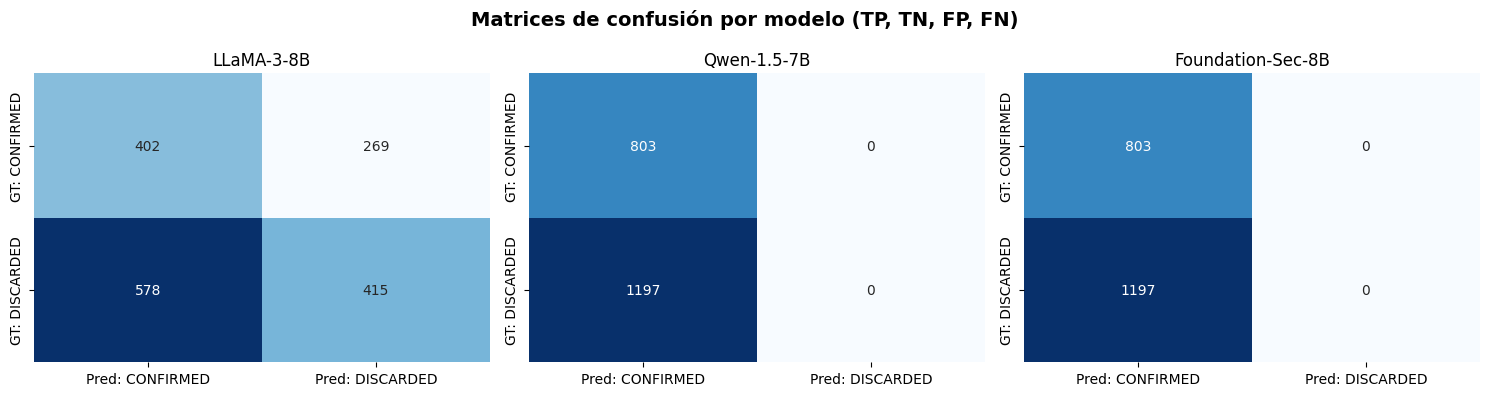

💾 Imagen guardada en: ./run_20251015_175126/confusion_matrices_viz.png
💾 CSV de métricas guardado en: ./run_20251015_175126/metrics_from_confusion.csv


In [3]:
# %% [markdown]
# 📊 Matrices de confusión y métricas derivadas por modelo (TP, TN, FP, FN)

# %%
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score
)

# === Datos base (Tabla 13) ===
data = [
    ["LLaMA-3-8B", 402, 415, 578, 269],
    ["Qwen-1.5-7B", 803, 0, 1197, 0],
    ["Foundation-Sec-8B", 803, 0, 1197, 0],
]
df = pd.DataFrame(data, columns=["Modelo", "TP", "TN", "FP", "FN"])
display(df)

# === Calcular métricas ===
metric_rows = []
for _, row in df.iterrows():
    TP, TN, FP, FN = row["TP"], row["TN"], row["FP"], row["FN"]
    model = row["Modelo"]

    # Reconstruir vectores binarios simulados
    y_true = np.array([1]*TP + [0]*FN + [1]*FP + [0]*TN)
    y_pred = np.array([1]*TP + [1]*FN + [0]*FP + [0]*TN)

    f1  = f1_score(y_true, y_pred, zero_division=0)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    bal = balanced_accuracy_score(y_true, y_pred)
    kap = cohen_kappa_score(y_true, y_pred)

    metric_rows.append({
        "Modelo": model,
        "F1-Score": round(f1, 3),
        "Precisión": round(pre, 4),
        "Recall": round(rec, 4),
        "MCC": round(mcc, 3),
        "Balanced Acc.": round(bal, 4),
        "Kappa": round(kap, 4)
    })

metrics_df = pd.DataFrame(metric_rows)
display(metrics_df)

# === Visualización de matrices de confusión ===
matrices = {}
for _, row in df.iterrows():
    model = row["Modelo"]
    cm = np.array([[row["TP"], row["FN"]],
                   [row["FP"], row["TN"]]])
    matrices[model] = cm

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (model, cm) in zip(axes, matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                xticklabels=["Pred: CONFIRMED", "Pred: DISCARDED"],
                yticklabels=["GT: CONFIRMED", "GT: DISCARDED"])
    ax.set_title(model)
plt.suptitle("Matrices de confusión por modelo (TP, TN, FP, FN)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# === Guardar resultados ===
# RUN_DIR = "./run_20251015_175126"
# img_path = os.path.join(RUN_DIR, "confusion_matrices_viz.png")
# csv_path = os.path.join(RUN_DIR, "metrics_from_confusion.csv")
# metrics_df.to_csv(csv_path, index=False, encoding="utf-8")
# fig.savefig(img_path, dpi=300, bbox_inches="tight")

print(f"💾 Imagen guardada en: {img_path}")
print(f"💾 CSV de métricas guardado en: {csv_path}")


**Celda auxiliar o de soporte.**

Ejecución complementaria necesaria para el flujo general del experimento.


In [ ]:
import nbformat
import os
from IPython import get_ipython

def remove_widgets_metadata():
    # Obtener la ruta del notebook actual
    # Esto funciona tanto en Jupyter Lab/Notebook como en Google Colab
    try:
        # Para Jupyter Lab/Notebook
        notebook_path = get_ipython().config['FileContentsManager']['root_dir'] + '/' + get_ipython().config['FileContentsManager']['path']
    except Exception:
        # Para Google Colab (asume que estás en el directorio de trabajo actual)
        # Si el notebook está en Google Drive, asegúrate de que Drive esté montado
        # y que el notebook esté en el directorio actual o proporciona la ruta completa.
        # Por ejemplo, si el notebook se llama "MiNotebook.ipynb" y está en /content/
        # puedes usar: notebook_path = "MiNotebook.ipynb"
        # O si está en Drive montado: notebook_path = "/content/drive/MyDrive/MiCarpeta/MiNotebook.ipynb"
        
        # Una forma más robusta para Colab es obtener el nombre del archivo actual
        # y asumir que está en el directorio actual o donde lo hayas guardado.
        # Para simplificar, si no estás seguro, puedes reemplazar la siguiente línea
        # con la ruta completa a tu archivo .ipynb
        print("No se pudo determinar la ruta automáticamente. Por favor, introduce la ruta completa de tu notebook:")
        notebook_path = input("Ruta del notebook (ej: /content/MiNotebook.ipynb): ")
        if not os.path.exists(notebook_path):
            print(f"Error: El archivo '{notebook_path}' no existe. Por favor, verifica la ruta.")
            return

    print(f"Intentando procesar el notebook: {notebook_path}")

    # Cargar el notebook
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_content = nbformat.read(f, as_version=4)

    # Verificar y eliminar el bloque 'widgets' si existe
    if 'metadata' in notebook_content and 'widgets' in notebook_content['metadata']:
        print("Se encontró el bloque 'metadata.widgets'. Eliminando...")
        del notebook_content['metadata']['widgets']
        print("Bloque 'metadata.widgets' eliminado.")
        
        # Guardar el notebook modificado
        with open(notebook_path, 'w', encoding='utf-8') as f:
            nbformat.write(notebook_content, f)
        print("Notebook guardado exitosamente sin el bloque 'metadata.widgets'.")
        print("Ahora puedes descargar este archivo y subirlo a GitHub.")
    else:
        print("El bloque 'metadata.widgets' no se encontró o ya ha sido eliminado. El notebook ya debería ser compatible con GitHub.")

# Ejecutar la función
remove_widgets_metadata()

No se pudo determinar la ruta automáticamente. Por favor, introduce la ruta completa de tu notebook:
